In [6]:
from os.path import dirname, abspath,join
from os import makedirs
import sys
import numpy as np
import pandas as pd
import json
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

root_path = dirname(abspath("./"))
import sys
sys.path.append(root_path)
from proT.predict import *

# plotting standard settings
plt.rcParams['figure.dpi'] = 100 #360 # standard is 360 but for set to 100 for practical visualization on the notebook
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['lines.linewidth'] = 1.5

In [92]:
# TODO: documentation
import torch
from torchmetrics.regression import R2Score, MeanSquaredError, MeanAbsoluteError

@torch.no_grad()
def eval_df_torchmetrics(
    y_pred: torch.Tensor,          # (B, S, D)
    y_true: torch.Tensor,          # (B, S, D)
    mask: torch.Tensor | None = None,  # (B, S) bool, True = valid
    feature_names: list[str] | None = None,
) -> pd.DataFrame:
    
    if not isinstance(y_pred, torch.Tensor):
        print("Converted output to torch tensor")
        y_pred = torch.tensor(y_pred)
        
    if not isinstance(y_true, torch.Tensor):
        print("Converted target to torch tensor")
        y_true = torch.tensor(y_true)
    
    if y_pred.shape != y_true.shape or y_true.ndim != 3:
        print(f"Found output shape {y_pred.shape} and target shape {y_true.shape}")
        raise ValueError("Expected matching (B,S,D) tensors.")
    B, S, D = y_true.shape
    device = y_true.device

    if feature_names is not None and len(feature_names) != D:
        raise ValueError(f"feature_names length {len(feature_names)} must equal D={D}")
    
    if D > 1:
        labels = feature_names or [f"f{d}" for d in range(D)]
    else:
        labels = None

    # Per-sample metrics (over S), returned per-feature (D)
    r2_metric  = lambda: R2Score(multioutput="raw_values").to(device)
    mse_metric = lambda: MeanSquaredError().to(device)
    mae_metric = lambda: MeanAbsoluteError().to(device)

    rows = []
    has_mask = mask is not None
    if has_mask:
        if mask.shape != (B, S):
            raise ValueError(f"mask must be (B,S); got {mask.shape}")

    for b in range(B):
        idx = mask[b] if has_mask else slice(None)
        yt = y_true[b, idx, :]   # (S_b, D)
        yp = y_pred[b, idx, :]   # (S_b, D)

        if yt.numel() == 0:  # no valid steps → fill zeros
            r2 = torch.zeros(D, device=device)
            mse = torch.zeros(D, device=device)
            mae = torch.zeros(D, device=device)
        else:
            r2  = r2_metric()(yp, yt)   # (D,)
            mse = mse_metric()(yp, yt)  # (D,)
            mae = mae_metric()(yp, yt)  # (D,)

        r2  = r2.detach().cpu().tolist()
        mse = mse.detach().cpu().tolist()
        mae = mae.detach().cpu().tolist()

        if D > 1 and labels is not None:
            for d, name in enumerate(labels):
                rows.append({"index": b, "feature": name, "R2": r2[d], "MSE": mse[d], "MAE": mae[d]})
        else:
            rows.append({"index": b, "R2": r2, "MSE": mse, "MAE": mae})

    return pd.DataFrame(rows)




def plot_predictions(
    sample_id: int, var_index: int, x_index: int, val_index: int, target_array: np.ndarray, 
    output_array: np.ndarray, title_map: dict=None, 
    save_dir: str=None, tag: str=None):
    
    vars = np.unique(target_array[:,:,var_index])
    vars = vars[~np.isnan(vars)]
    num_vars = len(vars)
    
    fig = plt.figure(figsize=(6*num_vars, 6))
    gs = gridspec.GridSpec(1, num_vars, wspace=0.3)

    if output_array.shape[-1] > 1:
        value = output_array[:,:,0].copy()
    else:
        value = output_array.copy()
    
    target = target_array.copy()
    
    # de-normalize
    value *= 10
    target[:, :, val_index] *= 10
    
    # get min and max value for xaxis_lim
    c = np.concatenate([value[sample_id],target[sample_id, :, val_index]])
    d = c[~(np.isnan(c))]
    min_val = np.min(d)
    max_val = np.max(d)
    
    for i,var in enumerate(vars):
        var_mask = target[sample_id, :, var_index] == var
        x = target[sample_id, :, x_index][var_mask]
        y_out = value[sample_id][var_mask]
        y_trg = target[sample_id, :, val_index][var_mask]
        ax = fig.add_subplot(gs[i])
        ax.plot(x, y_out, label="prediction")
        ax.plot(x, y_trg, label="target")
        ax.set_ylabel(r"$\Delta R [\%]$")
        ax.set_xlabel("Cycle Number")
        ax.set_xlim(0,x[-1])
        ax.set_ylim(min_val, max_val)
        
        # add metrics
        mask = torch.logical_not(torch.tensor(target[sample_id,:,val_index][var_mask]).isnan())
        df_met = eval_df_torchmetrics(
            y_pred=torch.tensor(y_out).unsqueeze(0).unsqueeze(-1), 
            y_true=torch.tensor(y_trg).unsqueeze(0).unsqueeze(-1), mask=mask.unsqueeze(0))
        mae = df_met.loc[0,"MAE"]
        r2 = df_met.loc[0,"R2"]
        
        title = (title_map[var]) if title_map is not None else var
        
        ax.set_title(f"{title}: MAE={mae:.2f}, R2={r2:.2f}")
        ax.legend()
    
    # optional export
    filename = f"prediction_sample_{sample_id}_{tag}.pdf"
    if save_dir is not None:
        makedirs(save_dir, exist_ok=True)
        out_path = join(save_dir, filename)
        fig.savefig(out_path, format="pdf", bbox_inches="tight")
    
    plt.show()



def plot_attention(sample_id: int, cross_att_array: np.ndarray, input_array: np.ndarray, save_dir: str=None, tag: str=None):
    
    if len(cross_att_array.shape) == 4:
        h_idx = 1
        print(f"MHA detected!\nAttention shape: {cross_att_array.shape} summing on axis {h_idx}")
        attention = cross_att_array.sum(axis=1)
        print(f"new attention shape {attention.shape}")
    else:
        attention = cross_att_array
    
    att = attention[sample_id]
    N, M = att.shape
    input_miss_bool = np.isnan(input_array[sample_id,:,val_index].squeeze())
    input_miss = input_miss_bool[np.newaxis,:].astype(int)

    fig = plt.figure(figsize=(6,6))
    gs = gridspec.GridSpec(2, 1, height_ratios=[10, 1], hspace=0.2)

    # Main heatmap axis
    ax0 = fig.add_subplot(gs[0])
    divider0 = make_axes_locatable(ax0)
    cax0 = divider0.append_axes("right", size="5%", pad=0.1)
    im0 = ax0.imshow(att, cmap='viridis', aspect='auto', origin='lower')
    
    cbar = fig.colorbar(im0, cax=cax0, label='Attention Score Value')
    cbar.formatter.set_powerlimits((0, 0))
    cbar.update_ticks()

    # Optional: Render the scientific notation with LaTeX for a cleaner look    
    cbar.formatter.set_useMathText(True)
    cbar.update_ticks()
    
    
    ax0.set_xticks([])
    ax0.set_ylabel("Queries")
    #ax0.set_title("Heatmap with Boolean Mask")
    
    h, w = att.shape[:2]  # height, width

    ax0.set_xticks([0, w-1])
    ax0.set_xticklabels([0, w-1])
    ax0.set_yticks([0, h-1])
    ax0.set_yticklabels([0, h-1])
    

    # Boolean mask axis
    ax1 = fig.add_subplot(gs[1], sharex=ax0)
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.1)
    im1 = ax1.imshow(input_miss, cmap='Greys', aspect='auto', origin='upper', vmin=0, vmax=1)
    fig.colorbar(im1, cax=cax1, ticks=[0, 1], label='NAIM')
    cax1.set_yticklabels(['0', r'$-\infty$'])

    ax1.set_yticks([])
    ax1.set_xlabel("Keys")
    
    # export
    filename = f"scores_sample_{sample_id}_{tag}.pdf"
    if save_dir is not None:
        makedirs(save_dir, exist_ok=True)
        out_path = join(save_dir, filename)
        fig.savefig(out_path, format="pdf", bbox_inches="tight")
    
    plt.show()
    


def get_group_score(sample_id: int, group_index: int, val_index: int, cross_att_array: np.ndarray, input_array: np.ndarray):
    
    cross_att = cross_att_array[sample_id]
    cumul_scores = np.mean(cross_att, axis=0)
    
    group_array = np.unique(input_array[sample_id,:,group_index])
    group_array = group_array[~np.isnan(group_array)]
    count_dict = {}
    for group in group_array:

        mask = np.logical_and(
            input_array[sample_id, :, group_index] == group, 
            ~np.isnan(input_array[sample_id, :, val_index]))
        count_dict[group] = np.mean(cumul_scores[mask])
    
    return pd.DataFrame.from_dict(count_dict, orient='index').reset_index()



def make_plots(
    sample_id: int, var_index: int, target_array: np.ndarray, 
    output_array: np.ndarray, cross_att_array: np.ndarray, title_map: dict=None, 
    save: bool=False):
    
    plot_predictions(sample_id, var_index, target_array, output_array, title_map, save)
    plot_attention(sample_id, cross_att_array, input_array, save)

## Load Experiment

In [8]:
datadir_path = r"../data/input"
config_path = r"../experiments/training/proT/InnosuisseMS/config_proT_dyconex_v5_5.yaml"
checkpoint_path = r"../experiments/training/proT/InnosuisseMS/k_0/checkpoints/best_checkpoint.ckpt"

config = OmegaConf.load(config_path)
input_array, output_array, target_array, cross_att_array, enc_self_att_array, dec_self_att_array = predict_test_from_ckpt(config, datadir_path, checkpoint_path, show_trg_max_idx = 0, cluster=False)


Global seed set to 42
c:\ProgramData\anaconda3\envs\prochain_transformer\Lib\site-packages\pytorch_lightning\utilities\migration\utils.py:51: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.5.0.post0, which is newer than your current Lightning version: v2.0.3
  rank_zero_warn(


Test dataset selected (default).
Predicting...


100%|██████████| 1/1 [00:04<00:00,  4.99s/it]


In [52]:
torch.tensor(target_array[0,:,4]).isnan().shape

torch.Size([400])

In [68]:
val_idx = 4
var_idx = 2

t = torch.tensor(target_array[:,:,[val_idx,var_idx]])
t.shape

torch.Size([4, 400, 2])

In [71]:

values = t[..., 0]            # (B, L)
vars   = t[..., 1].long()     # (B, L), categorical index
C = 3            # int

B, L = values.shape
out = torch.zeros(B, L, C, device=values.device, dtype=values.dtype)

# scatter along the last dim using vars as the index
out.scatter_(dim=2, index=vars.unsqueeze(-1), src=values.unsqueeze(-1))

tensor([[[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0188, 0.0000],
         [0.0000, 0.0294, 0.0000],
         ...,
         [0.0000, 0.0000,    nan],
         [0.0000, 0.0000,    nan],
         [0.0000, 0.0000,    nan]],

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0181, 0.0000],
         [0.0000, 0.0239, 0.0000],
         ...,
         [0.0000, 0.0000, 0.3774],
         [0.0000, 0.0000, 0.3795],
         [0.0000, 0.0000, 0.3922]],

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0050, 0.0000],
         [0.0000, 0.0150, 0.0000],
         ...,
         [0.0000, 0.0000,    nan],
         [0.0000, 0.0000,    nan],
         [0.0000, 0.0000,    nan]],

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0138, 0.0000],
         [0.0000, 0.0645, 0.0000],
         ...,
         [0.0000, 0.0000,    nan],
         [0.0000, 0.0000,    nan],
         [0.0000, 0.0000,    nan]]])

In [53]:
eval_df_torchmetrics(y_pred=output_array[:,:,0:1], y_true=target_array[:,:,4:5], mask=torch.logical_not(torch.tensor(target_array[:,:,4]).isnan()))

Converted output to torch tensor
Converted target to torch tensor


,index,R2,MSE,MAE
0,0,-1.369633,0.174831,0.364222
1,1,0.972383,0.000242,0.012779
2,2,0.552118,0.006377,0.059376
3,3,0.408299,0.008371,0.079273


In [ ]:
dataset_name = config["data"]["dataset"][3:]
print(dataset_name)

dx_250806_panel_200_pad


In [ ]:
# files
builds_dir = "../../proT_pipeline/data/builds"
var_vocab_filepath = join(builds_dir, dataset_name, "output/variables_vocabulary.json_trg")
pos_vocab_filepath = join(builds_dir, dataset_name, "output/position_vocabulary.json")
rating_filepath = join(builds_dir, dataset_name, "control/steps_selected.xlsx")

with open(var_vocab_filepath, 'r', encoding='utf-8') as file:
    inv_var_dict = json.load(file)
    
with open(pos_vocab_filepath, 'r', encoding='utf-8') as file:
    inv_pos_dict = json.load(file)

df_rating = pd.read_excel(rating_filepath)

# maps
var_map = {v: k[:3] for k, v in inv_var_dict.items()}
pos_map = {v: int(float(k)) for k, v in inv_pos_dict.items()}
rate_map = df_rating.set_index("Step")["Bewertung "].to_dict()
process_map = df_rating.set_index("Step")["Process"].to_dict()

In [55]:
# define data indices
var_index = 2
x_index = 3
val_index = 4

# get variables
vars = np.unique(target_array[:,:,var_index])
vars = vars[~np.isnan(vars)]
num_vars = len(vars)

title_map = {
    1.0: "Sense A",
    2.0: "Sense B"
}

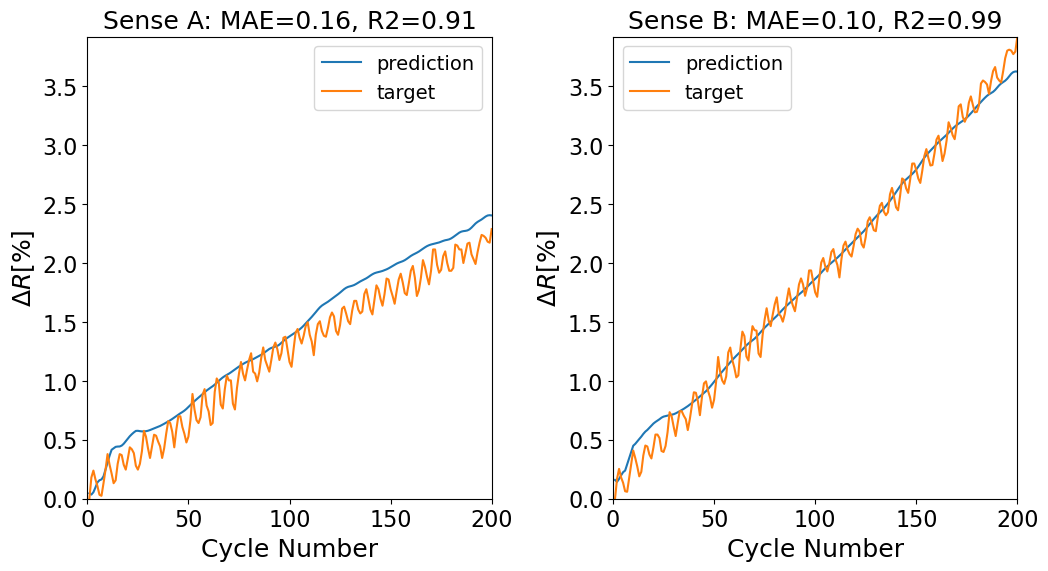

In [97]:
sample_id = 1

plot_predictions(sample_id, var_index, x_index=3, val_index=4, target_array=target_array, output_array=output_array, title_map=title_map, save_dir="./figures", tag="example")

#make_plots(sample_id, var_index, target_array, output_array, cross_att_array)

MHA detected!
Attention shape: (4, 2, 400, 921) summing on axis 1
new attention shape (4, 400, 921)


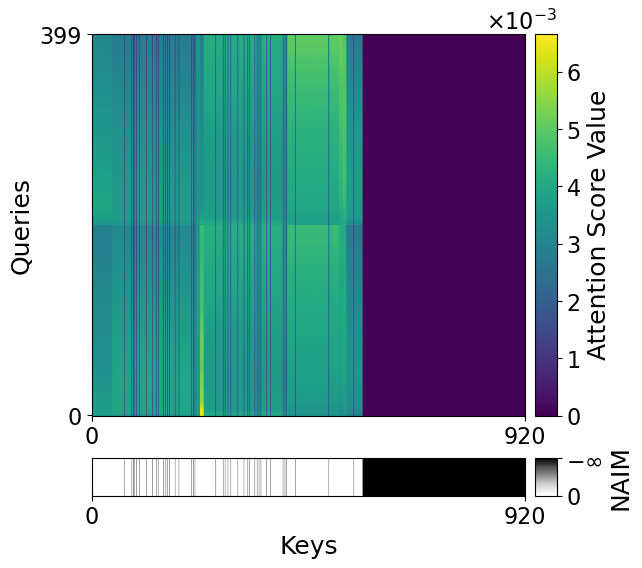

In [63]:
plot_attention(sample_id, cross_att_array, input_array, save_dir="./figures", tag="example")

In [ ]:
group_index = x_index
df = get_group_score(sample_id, group_index,val_index, cross_att_array, input_array)  
df["PaPos"] = df["index"].map(pos_map)
df["rating"] = df["PaPos"].map(rate_map)
df["process"] = df["PaPos"].map(process_map)
df

IndexError: boolean index did not match indexed array along dimension 0; dimension is 400 but corresponding boolean dimension is 921

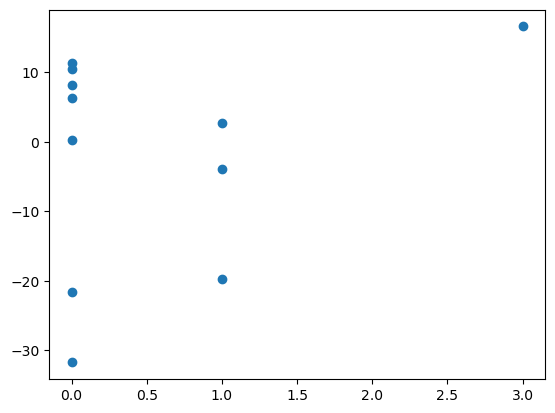

In [ ]:
plt.scatter(df["rating"],df[0])